
# Creation of a quantization, use and evaluation pipeline, featuring LLaMA2 7B model and GPTQ

In this notebook, we evaluate the impact quantization has in a common use LLM model, in our case LLaMA 2 7B, evaluating it in a sentiment analysis task. Our pipeline is defined as follows:
- Add a classification layer at the end of the not-quantized model and train this new model with our dataset.
- Quantize the model using **GPTQ** in three variants, 8bit, 4 bit and 3bit quantization.
- Compare the performance of our models (not quantized, 4bits 8bits and 3 bits) in terms of precission, memory use, inference speed and emissions.

![Pipeline Diagram](./GPTQ_Pipeline.png)

We follow this approach because it is the easiest approach to follow. Another option would be to firstly quantize the base model and then add the classification layer and train it. In fact, one could think this approach is better than the previously exposed. However, lots of problems are encountered doing this because fine tuning an already quantized model is not a good practice. 

### Goals
1. Analize the impact quantization has on performance.
2. Compare the efficiency and precision of the quantized models with the not-quantized model.


## GPTQ

GPTQ (Gradient Post-Training Quantization) is an advanced quantization method designed specifically for fine-tuning and optimizing large language models. It was developed to address the need for efficient deployment of these models without significant loss in accuracy. By applying quantization techniques at the post-training stage (therefore a PTQ method), GPTQ reduces the precision of model weights while preserving critical characteristics of the original model, making it ideal for scenarios where memory and computational resources are limited.

The core idea behind GPTQ is gradient-guided quantization, which uses gradient-based metrics to prioritize the importance of different weights in the model. Unlike naive quantization methods that treat all weights equally, GPTQ identifies weights that have the greatest impact on the model's performance and assigns them higher precision values. Typically, these critical weights are left at higher precision, such as 16-bit floats, while less influential weights are quantized to lower precision formats like 8-bit or 4-bit integers. This selective approach minimizes the quantization error and helps maintain model accuracy. These weights are identified using a second-order approximation based on the Hessian matrix. This approach allows the measurement of the model's sensitivity to changes in its weights, minimizing accuracy loss. First, the squared error introduced by quantizing each weight individually is computed. The metric used is: $\|WX - \hat{W}X\|^2$, where W represents the original weights, $\hat{W}$ are the quantized weights, and X corresponds to the layer inputs. Subsequently, an approximation of the Hessian matrix is calculated to estimate each weight's contribution to the overall error. Using this information, weights are ranked by their impact, and those with the highest influence on accuracy are processed first.

Once identified, weights are processed through an iterative and adaptive approach that adjusts the remaining weights to compensate for the error introduced by quantization. This treatment involves the following steps:
1. Adaptive Quantization: Each weight is quantized to the desired precision level. Then, the remaining weights are dynamically updated to minimize the cumulative error caused by the quantization of the processed weight.
2. Global Approach: Instead of separating weights into categories of high and low impact, GPTQ adopts a holistic strategy, optimizing all weight interactions within the same layer.
3. Block-wise Processing: In large-scale models, weights are divided into blocks (e.g., column blocks). Each block is quantized independently to enhance computational efficiency, significantly reducing the cost of processing very large matrices.

A key feature of GPTQ is its iterative approach to quantization. Instead of quantizing all weights at once, GPTQ applies quantization layer by layer, recalculating gradients at each step. This allows the method to adjust for quantization-induced errors dynamically and ensures that the final model remains robust. The process results in a model with a significantly smaller memory footprint while retaining most of its predictive performance. Layer-by-layer compression in GPTQ relies on an independent optimization strategy for each layer. This ensures that the impact of quantization on one layer does not propagate uncontrollably to the rest of the model. The procedure follows these steps:
1. Input and Output of Each Layer: A small dataset is used to calculate the inputs (X) and outputs for each layer of the model. These inputs and outputs serve as a reference to assess the quantization impact.
2. Local Optimization: For each layer, an optimization problem is solved to minimize the difference between the original output (with full-precision weights) and the output generated with quantized weights. This ensures each layer is locally adjusted to preserve the model’s overall accuracy.
3. Sequential Processing: The model is quantized sequentially, layer by layer. The inputs to each layer are updated using the outputs from already quantized layers. This approach ensures efficient quantization while maintaining consistency across the model.

Finally, Inference with models quantized using GPTQ incorporates key features to optimize performance:
1. Dynamic De-quantization: Weights stored in low precision (e.g., 3 or 4 bits) are dynamically converted to higher precision during runtime. This enables accurate computations without significantly increasing storage requirements.
2. Optimized Kernels: Custom kernels are used to perform matrix-vector multiplications, where the matrix is quantized, and the vector remains in high precision. These kernels are designed to minimize memory movement, resulting in significant acceleration of inference time.
3. Memory Reduction: Quantization significantly reduces the memory required to store model weights. For example, a 3-bit quantized GPT-175B model can be executed on a single NVIDIA A100 GPU, compared to multiple GPUs required for the non-quantized version.
4. Efficiency in Generative Tasks: In tasks like text generation, where the model processes one token at a time, this strategy improves inference speed by reducing the time needed to access and process weights.

In summary, GPTQ combines the efficiency of lower precision computations with the precision of gradient-guided weight selection, allowing large models to operate in constrained environments without sacrificing accuracy. This makes it an essential tool for deploying modern large language models in real-world applications.

## Hardware and software

### Hardware
- CPU: Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
- RAM: 985 GB
- GPU: NVIDIA A100-PCIE-40GB
### Software
For this project, we used the following python libraries: torch, transformers, time and datasets, among others. Of course, all the libraries that these libraries have dependencies with are needed too.
We also used some other libraries or tools that help to evaluate the results. For example, the library CodeCarbon was used to collect emissions data, and the Weights and Biases (Wandb) platform was used to collect and visualize metrics. 


## Project pipeline

### 1. Base model preparation
The base model used is **LLaMA 2 (7B)**. We added a classifier layer to it by loading it with the LlamaForSequenceClassification function from the Transformers library. Then, fine tuning was performed using the **TweetEval** dataset, focusing on the sentiment classification task on its training subset. To make the fine-tuning more efficient and lightweight, Low-Rank Adaptation (LoRA) was applied to the attention layers using the PEFT library, reducing the number of trainable parameters. Training was carried out on a single  NVIDIA A100 40GB GPU using the Hugging Face ***Trainer*** API with a learning rate of $2 \times 10^{-5}$, a batch size of 8, and a total of 3 epochs.

### 2. Quantization 
Quantization was performed using **GPTQ**. With this quantization method we took 3 quantization options: **8 bits**, **4 bits** and **3 bits**.
This leads us to have 4 different models: **quantized to 8 bits**, **quantized to 4 bits**, **quantized to 3 bits** and **not quantized**.

### 3. Evaluation
These four models were evaluated and compared in terms of: **accuracy**, **macro F1 score**, **memory use**, **inference speed** and **emissions**. The dataset used was the same we used for the training before, but we used the test subset.


## Results

### Accuracy results
We now show the results obtained for the accuracy of each of the four models:

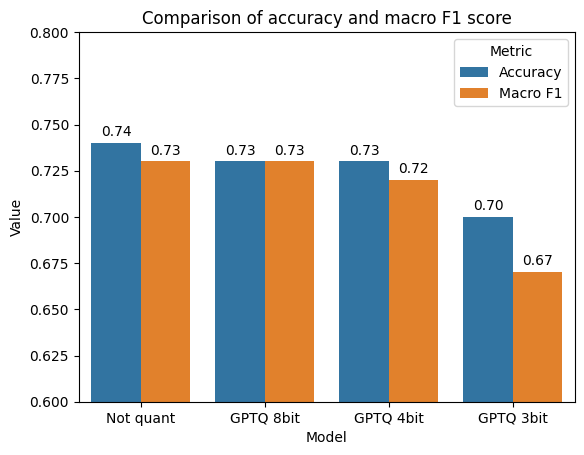

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit'],
    'Accuracy': [0.74, 0.73, 0.73, 0.70],
    'Macro F1': [0.73, 0.73, 0.72, 0.67]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of accuracy and macro F1 score')
plt.ylim(0.6, 0.8)
plt.show()

We observe how the accuracy is higher with the base model and, between the quantized models, the 8-bit variant has a higher accuracy, although differences are minimal, not only between the quantized models, but also betweem the 8 and 4 bit variants and the base model. The only model that gets lower results is the 3bit variant, with 5.44% less accuracy than the base model and 4.10% less than the other two quantized models.


### Memory use results

Measuring memeory needs is not an easy task. We decided to check the maximum memory need while inference (in GPU). Note that this measure tends to be higher due to needs associated with inference, specially when using batches.

We only measured this and not the disk memory required because of the way we store the models. Since we used LoRA to fine tune and train our base model with the classification layer, we don't store the whole model explicitly, but only the LoRA adpaters generated. Therefore, we are unable to compare additional memory usage metrics, such as disk memory requirements.

Now we show the maximum memory needed for inference for each model and inference configuration:

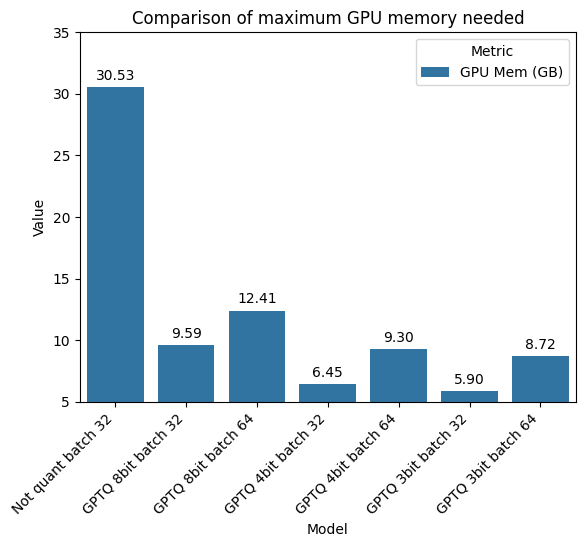

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'GPTQ 8bit batch 32', 'GPTQ 8bit batch 64', 'GPTQ 4bit batch 32', 'GPTQ 4bit batch 64', 'GPTQ 3bit batch 32', 'GPTQ 3bit batch 64'],
    'GPU Mem (GB)': [30.53, 9.59, 12.41, 6.45, 9.30, 5.90, 8.72]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of maximum GPU memory needed')
plt.ylim(5.0, 35.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the maximum memory usage in GPU during inference increases with batch size for all models. The bigger the batch size, the higher the memory needs. In addition to this, we see how the base model needs considerable more memory compared to all quantized models, and between the quantized models, the 3bit variant requires less memory than the others. In fact, the lower the bit count, the less memory needed.

### Inference speed results

In this section we show the results obtained for inference time and quantization time:  

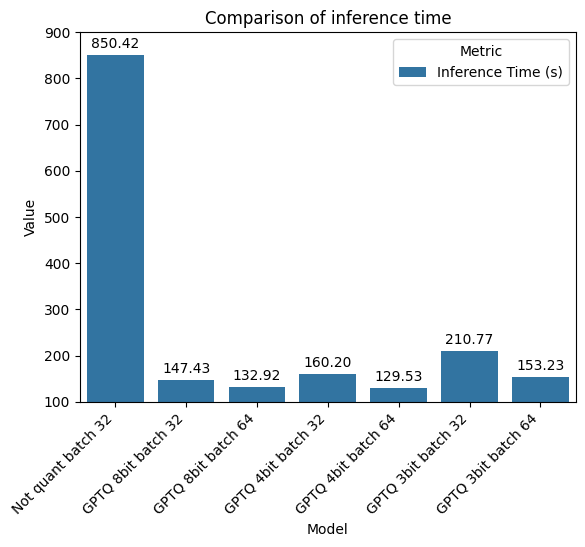

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'GPTQ 8bit batch 32', 'GPTQ 8bit batch 64', 'GPTQ 4bit batch 32', 'GPTQ 4bit batch 64', 'GPTQ 3bit batch 32', 'GPTQ 3bit batch 64'],
    'Inference Time (s)': [850.42, 147.43, 132.92, 160.20, 129.53, 210.77, 153.23]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of inference time')
plt.ylim(100.0, 900.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how, with a big difference, the base model is the slowest one. All the quantized models are faster and between them, the 8 and 4 bit variants are faster than the 3 bit variants, so the use of a lower bit model don't seem to make the model faster.

The use of a bigger batch size also shows improvement in speed but difference is not specially big.

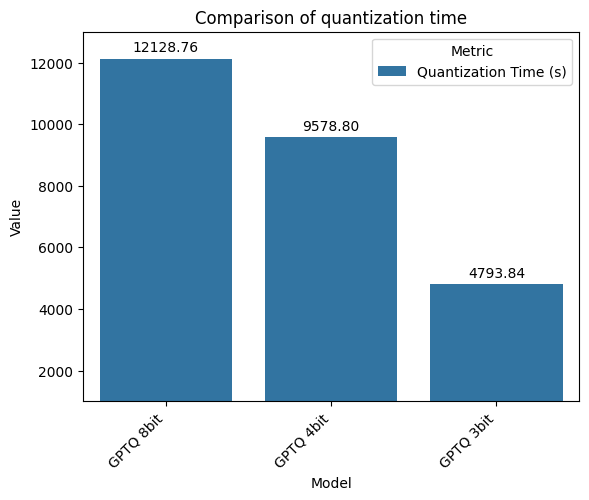

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit'],
    'Quantization Time (s)': [12128.76, 9578.80, 4793.84]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of quantization time')
plt.ylim(1000.0, 13000.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the 3bit variant needs substantially less time to be quantized than the other two. And between those, the 4 bit variant needs considerably less time. 

However, results obtained for quantization time with **GPTQ** can't be taken very seriously becasue the nature of this quantization method. This method needs a dataset to perform quantization, and our empirical experience shows that the first time the model is quantized, quanitzation is really slow. However, the following quantizations need considerably less time. This is the case with our experiments, since we tested the model with 32 and 64 sized batches.

### Emissions results

The emissions are a little challeging to measure and compare. This is because we need to decide if we take into account the emissions generated during the quantization of the models. Our approach will show the resuts obtained for evaluation separated from the emissions for the quantization process, but will take them into consideration when comparing. We will measure the emissions of CO<sub>2</sub> in kilograms of CO<sub>2</sub>-equivalents \[CO<sub>2</sub>eq\]

The emissions generated by the evaluation process and the quantization were:

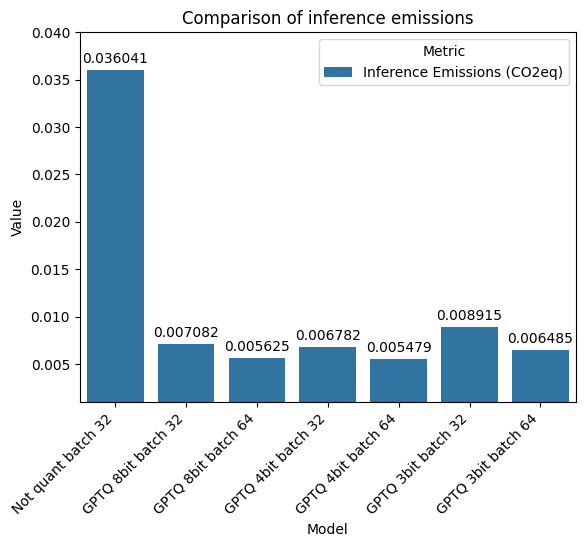

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'GPTQ 8bit batch 32', 'GPTQ 8bit batch 64', 'GPTQ 4bit batch 32', 'GPTQ 4bit batch 64', 'GPTQ 3bit batch 32', 'GPTQ 3bit batch 64'],
    'Inference Emissions (CO2eq)': [0.036041, 0.007082, 0.005625, 0.006782, 0.005479, 0.008915, 0.006485]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of inference emissions')
plt.ylim(0.001, 0.04)
plt.xticks(rotation=45, ha='right')
plt.show()

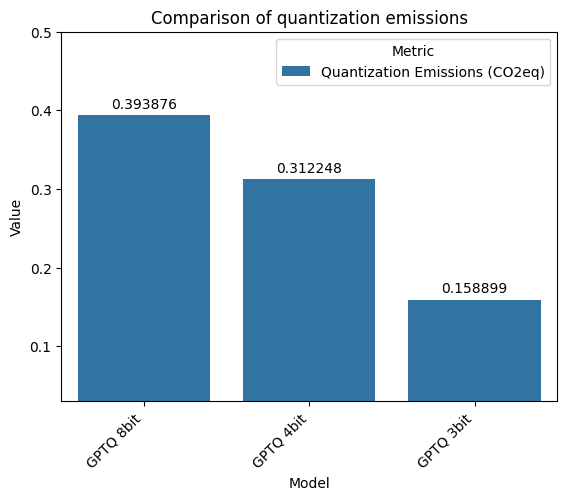

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit'],
    'Quantization Emissions (CO2eq)': [0.393876, 0.312248, 0.158899]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of quantization emissions')
plt.ylim(0.03, 0.5)
plt.xticks(rotation=45, ha='right')
plt.show()

Again, quantization emissions results follow the same trend seen before with quantization time results. The 4bit variant has lower emissions than the 8bit variant and the 3bit variant has even lower emissions.

However, as it was mentioned with quantization time, emissions for quantization with **GPTQ** can't be taken very seriously for the same reasons exposed before.


## Conclusions

Results show that:

1. Quantization does in fact reduce accuracy, and the lower the bit count, the higher this drop is. However, the drop with **GPTQ** is not as significant, as we saw. Accuracy remain close to the base model results, specially with 8 and 4 bit models.
2. Quantized models are noticeably better in terms of memory usage compared to the base model.
3. Quantized models with **GPTQ** are faster than the base model. However, quantization time for **GPTQ** models, specially 8 and 4 bit variants, is considerably high.
4. In a similar fashion as inference time, emissions are lower in the quantized models. This is coherent with the fact that the inference time is lower. However, with **GPTQ** the emissions generated with quantization are worth noting and be considered.

